# Mathematical Statistics Homework Assignment
#### Richárd Kiss - KAYXFT - 2023.05

# 1. Introduction

In this assignment I use a dataset that was generated as part of my PhD research. The dataset contains music playlists and song recommendations for these playlists generated with three different algorithms. In this assignment I am performing statistical analysis to compare these two algorithms in terms of recommendation performance.

## The two recommendation algorithms
### Algorithm 1.
The first algorithm recommends songs based solely on their popularity. It consistently returns the top $K$ most popular songs, irrespective of the particular songs present in the playlist for which we are making new song recommendations. Despite its simplicity, this approach is very effective and often used as a benchmark in the evaluation of recommendation systems.

### Algorithm 2. and 3.
The second algorithm employs Skip-Gram with negative sampling to learn insightful, low-dimensional song representations (denoted by $w_i \in \mathbb{R}^l$ for all songs $i$, where $l$ is the dimensionality of the representation). The core concept revolves around discerning whether song pairs originate from the original data distribution, $P_{orig}$, or from a synthetic noise distribution, $P_{noise}$.

The song pairs in the original distribution are generated by sampling songs from a playlist within a specific context window (of size $c$), and corresponding noise samples are created by randomly pairing songs that do not appear together within a context window (of the same size $c$).

To reduce computational demands, we ease the restriction of never appearing together. Since the co-appearance graph of songs is usually sparse, choosing two random songs seldom results in a pair that co-appears in the dataset. Although there's still a slim chance, this compromise generally speeds up the sampling process without drastically affecting the results. (You can find more details about this method  [here](https://www.baeldung.com/cs/nlps-word2vec-negative-sampling)).

Once we've learned the song representations $w$, we can use them to generate playlist recommendations. The process begins by selecting the 100 most similar songs for each song in the playlist. Then, we count the number of times a particular song appears within the 100 proximity of each song in the playlist and rank them in descending order. Finally, we return the top $K$ songs from this sorted list.

I also experimented with an other variant (referred as Algorithm 3. later on) of the Skip-Gram model, where I used hyperbolic representations instead of euclidian ones. (You can find more information about hyperbolic shallow embeddings and their desired properties [here](https://arxiv.org/pdf/1705.08039.pdf) and [here](https://arxiv.org/pdf/1809.01498.pdf))


## The recommendation dataset
I used the [Spotify Million Playlist Dataset](https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge) that contains 1 Million playlists (sequence of songs) with additional song, artist and album information. For this project I only use the song sequences without any additional information. (Also the dataset was filtered before learning the Skip-Gram models, songs appearing less than 30 times were discarded to reduce noise). In this assignment I am using recommendations generated with the above mentioned 3 algorithms. For each playlist I generated 100 recommendations based on the first 30 songs. When evaluating recommendation performance I use the remaining songs as ground truth. Also playlists used for the evaluation were never seen during training.


# 2. Statistical analysis
### First Hypothesis

I want to check whether the frequencies of songs (number of appearances in the dataset) comes from an exponential distribution. To test this I first fit an exponential distribution on the frequencies then I perform a one sample Kolmogorov-Smirnov test with the fitted exponential.

Reason: I plotted the frequencies and it looks similar to an exponential distribution, although verifying this is not particularly useful.

### Second Hypothesis

Recommendations generated with Algorithm 2. have higher recall ($\frac{TP}{TP+FN}$) on average than those generated with Algorithm 1. To test this I am performing a paired T-test on the recall values.

Reason: I want to verify that the Skip-Gram model is better than the baseline.

### Regression analysis

To see how similar Algorithm 2. and 3. are I compare their song level performance. In particular I am curious whether they miss the same songs or not. I compute the False Negative values for each song and algorithm - how many times a song was not recommended when it was in the playlist. If the two models are similar, I expect a high correlation between the song level false negative values.

Reason: If the two algorithms miss different songs, I could use them in an ensemble to improve recommendation performance.

In [1]:
import os
import json
import seaborn
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
DATA_FOLDER = "../data/"

In [3]:
def load(*path):
    with open(os.path.join(*path)) as f:
        return json.load(f)

idx2song = load(DATA_FOLDER, "metadata", "idx2song.json")
freqs = load(DATA_FOLDER, "metadata", "frequencies.json")
# it is necessary to remap song id-s to song names in the freqs json
freqs = {idx2song[k]: v for k,v in freqs.items()}
algo1 = load(DATA_FOLDER, "popularity.json")
algo2 = load(DATA_FOLDER, "euclidean.json")
qrels = load(DATA_FOLDER, "qrels.json")

## __First Hypothesis__

I want to confirm that the song frequencies come from an exponential distribution.

In [4]:
frequencies = np.array(list(freqs.values()))

<AxesSubplot: xlabel='song frequency', ylabel='Count'>

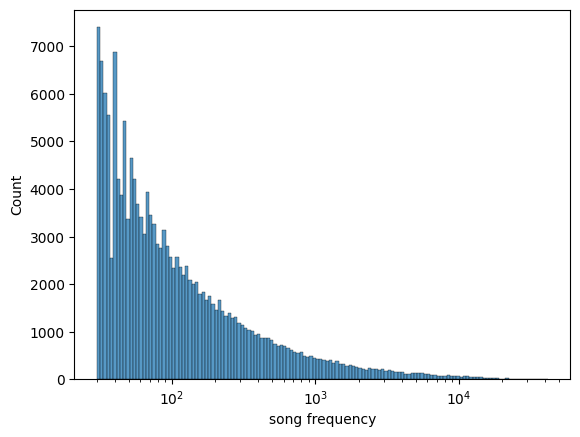

In [5]:
seaborn.histplot(data={"song frequency": frequencies}, x="song frequency", log_scale=True)

I first fit an exponential distribution to the data using Maximum Likelihood Estimation:

In [6]:
loc, scale = stats.expon.fit(frequencies)
print("loc", loc, "scale", scale)

loc 30.0 scale 299.4040398357059


Now comes the KS test, for which the null and alternative hypotheses are as follows:

$H_0: F_x(t) = F_0(t)$

$H_1: F_x(t) \neq F_0(t)$

So if we can not reject $H_0$ we can conclude that the data indeed comes from an exponential distribution at a given significance level. I used 95% significance level.

In [7]:
stat, p_value = stats.kstest(frequencies, "expon", args=(loc, scale))

alpha = 0.05

print("Test statistic", stat)
print("p value", p_value)

if p_value < alpha:
    print("We reject the null hypothesis and conclude that the data does not follow an exponential distribution.")
else:
    print("We fail to reject the null hypothesis and conclude that we don't have enough evidence to say the data does not follow an exponential distribution.")

Test statistic 0.3924889147332628
p value 0.0
We reject the null hypothesis and conclude that the data does not follow an exponential distribution.


So it seems that the data does not come from an exponential distribution, my intuition was not correct.

## __Second Hypothesis__

I want to confirm that Algorithm 2 can produce recommendations with higher recall on average with significance level 99%. So the null and alternative hypotheses are as follows:

$H_0: \mu_1 > \mu_2$

$H_1: \mu_1 \leq \mu_2$

If we can reject $H_0$ in favour of $H_1$, we can conclude that Algorithm 2 outperforms Algorithm 1 in terms of recall at significance level 99%.

In [8]:
# Helper functions to compute recall values for each playlist
def recall(tp, fn):
    return tp / (tp + fn)

def get_recalls(qrels, recs):
    for (q_id, q_data), (r_id, r_data) in zip(qrels.items(), recs.items()):
        assert q_id == r_id, f"ID mismatch {q_id} {r_id}"
        actual = set(q_data.keys())
        predicted = set(r_data.keys())
        tp = len(actual & predicted)
        fn = len(actual.difference(predicted))
        yield recall(tp, fn)

In [9]:
# compute recalls for the recommendations generated with Algorithm 1 and 2
recall1 = np.array(list(get_recalls(qrels, algo1)))
recall2 = np.array(list(get_recalls(qrels, algo2)))

In [10]:
# check the empirical mean of two lists
np.mean(recall2), np.mean(recall1)

(0.13159084123043216, 0.013046321769482273)

In [11]:
import numpy as np
from scipy import stats

# Perform paired t-test
t_stat, p_value = stats.ttest_rel(recall2, recall1, alternative='greater')

print("t statistic: ", t_stat)
print("p value: ", p_value)

# Choose significance level
alpha = 0.01

# Interpret the results
if p_value < alpha:
    print("We reject the null hypothesis and conclude that the mean of recall2 is significantly greater than the mean of recall1.")
else:
    print("We fail to reject the null hypothesis and conclude that we don't have enough evidence to say that the mean of recall2 is greater than the mean of recall1.")


t statistic:  246.58068655214413
p value:  0.0
We reject the null hypothesis and conclude that the mean of recall2 is significantly greater than the mean of recall1.


We confirmed that Algorithm 2. is significantly better in terms of average recall.

# __Regression analysis__
For this task I first need to prepare the data - compute false negative values for each song.

In [12]:
from tqdm import tqdm

# Helper function to prepare song metrics
def song_metrics(qrels, recs):
    metrics = {}
    def register_song(song):
        if song not in metrics:
            metrics[song] = {"tp": 0, "fp": 0, "fn": 0}
            
    for (q_id, q_data), (r_id, r_data) in tqdm(zip(qrels.items(), recs.items()), total=len(qrels)):
        assert q_id == r_id, f"ID mismatch {q_id} {r_id}"
        actual = set(q_data.keys())
        predicted = set(r_data.keys())
        for song in predicted:
            register_song(song)
            if song in actual:
                metrics[song]["tp"] += 1
            else:
                metrics[song]["fp"] += 1
                
        for song in actual:
            register_song(song)
            if song not in predicted:
                metrics[song]["fn"] += 1
    return metrics

In [13]:
# Load recommendations generated with Algorithm 3.
algo3 = load(DATA_FOLDER, "lorentz.json")

In [14]:
# Compute song metrics
m3 = song_metrics(qrels, algo3)
m2 = song_metrics(qrels, algo2)

100%|██████████████████████████████████| 84792/84792 [00:06<00:00, 13308.54it/s]


In [15]:
# I only consider songs that were recommended in both algorithm (Algorithm 2. and Algorithm 3.)
common_songs = set(m3.keys()) & set(m2.keys())
len(common_songs)

567706

In [16]:
# Put the false negatives in a list in the same order
fn3 = [m3[s]["fn"] for s in common_songs]
fn2 = [m2[s]["fn"] for s in common_songs]

First I check if there is correlation between the two variables. The null and alternative hypethesis are as follows:

$H_0:$ The correlation is zero

$H_1:$ The correlation is nonzero

In [17]:
# Correlation analysis
correlation, p_value = stats.pearsonr(fn2, fn3)

alpha = 0.05

print("Correlation coefficient: ", correlation)
print("p value: ", p_value)

# Interpret the results
if p_value < alpha:
    print(f"We reject the null hypothesis and conclude that there is a significant linear relationship between the two datasets, with a Pearson correlation coefficient of {correlation}.")
else:
    print("We fail to reject the null hypothesis and conclude that we don't have enough evidence to say there is a significant linear relationship between the two datasets.")

Correlation coefficient:  0.9951288406397137
p value:  0.0
We reject the null hypothesis and conclude that there is a significant linear relationship between the two datasets, with a Pearson correlation coefficient of 0.9951288406397137.


Next I perform a linear regression on the data

In [18]:
slope, intercept, _, _, _ = stats.linregress(fn2, fn3)

print("Slope: ", slope)
print("Intercept: ", intercept)
linear_model = lambda x: x*slope + intercept

Slope:  1.0209394246191135
Intercept:  0.006836979030544477


Visualization of the result

Text(0, 0.5, 'euclidean')

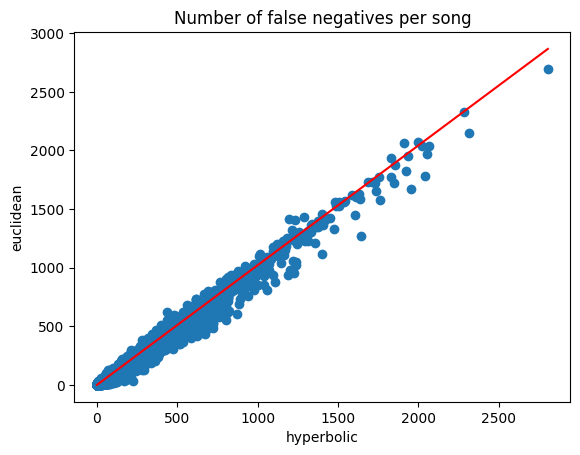

In [19]:
# Plot results
x = np.array([min(fn3), max(fn3)])
y = linear_model(x)
plt.scatter(fn3, fn2)
plt.plot(x, y, c="red")
plt.title("Number of false negatives per song")
plt.xlabel("hyperbolic")
plt.ylabel("euclidean")

So Algorithm 2. and 3. are really similar, I can not improve much on the false negative values by using them in an ensemble.